In [277]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from scipy.spatial import Voronoi, voronoi_plot_2d
from esda.moran import Moran, Moran_Local
from libpysal.weights import DistanceBand
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
import contextily as ctx
from shapely.ops import unary_union, nearest_points
import matplotlib.colors as mcolors

In [156]:
# Load the dataset
data = pd.read_csv('Preprocessed_Dataset.csv')  # Replace with your dataset path

In [157]:
data.head()

Measurement date  Station code  \
0  2017-01-01 00:00:00           101   
1  2017-01-01 01:00:00           101   
2  2017-01-01 02:00:00           101   
3  2017-01-01 03:00:00           101   
4  2017-01-01 04:00:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2    NO2     O3        CO  PM10  PM2.5  
0  0.004  0.059  0.002  0.499011  73.0   57.0  
1  0.004  0.058  0.002  0.499011  71.0   59.0  
2  0.004  0.056  0.002  0.499011  70.0   59.0  
3  0.004  0.056  0.002  0.499011  70.0   58.0  
4  0.003  0.051  0.002  0.499011  69.0   61.0

In [158]:
# Convert the 'Measurement date' column to datetime format
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Handle missing data
# Fill missing pollutant values with linear interpolation
pollutant_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

# Normalize pollutant levels
scaler = StandardScaler()
data[pollutant_columns] = scaler.fit_transform(data[pollutant_columns])

In [159]:
# Add date-related columns
data['Date'] = data['Measurement date'].dt.date
data['Month'] = data['Measurement date'].dt.to_period('M')  # Monthly period
data['Season'] = data['Measurement date'].dt.month % 12 // 3 + 1  # Seasons: 1=Winter, 2=Spring, 3=Summer, 4=Autumn

# Map season numbers to names for readability
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
data['Season'] = data['Season'].map(season_map)

In [160]:
# Daily Aggregation
daily_data = data.groupby(['Date', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

# Monthly Aggregation
monthly_data = data.groupby(['Month', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

# Use monthly_data for clustering
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
data_filtered = monthly_data.dropna()

In [161]:
# Step 2: Perform Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=42)
mds_coords = mds.fit_transform(data_filtered[pollutants])
data_filtered['MDS_X'] = mds_coords[:, 0]
data_filtered['MDS_Y'] = mds_coords[:, 1]


In [162]:
def categorize_location(lat, lon):
    if lat > 37.5:  # Replace with suitable thresholds
        return 'North'
    elif lat < 37.0:
        return 'South'
    else:
        return 'Central'

data_filtered['Zone'] = data_filtered.apply(lambda row: categorize_location(row['Latitude'], row['Longitude']), axis=1)
hue='Zone'

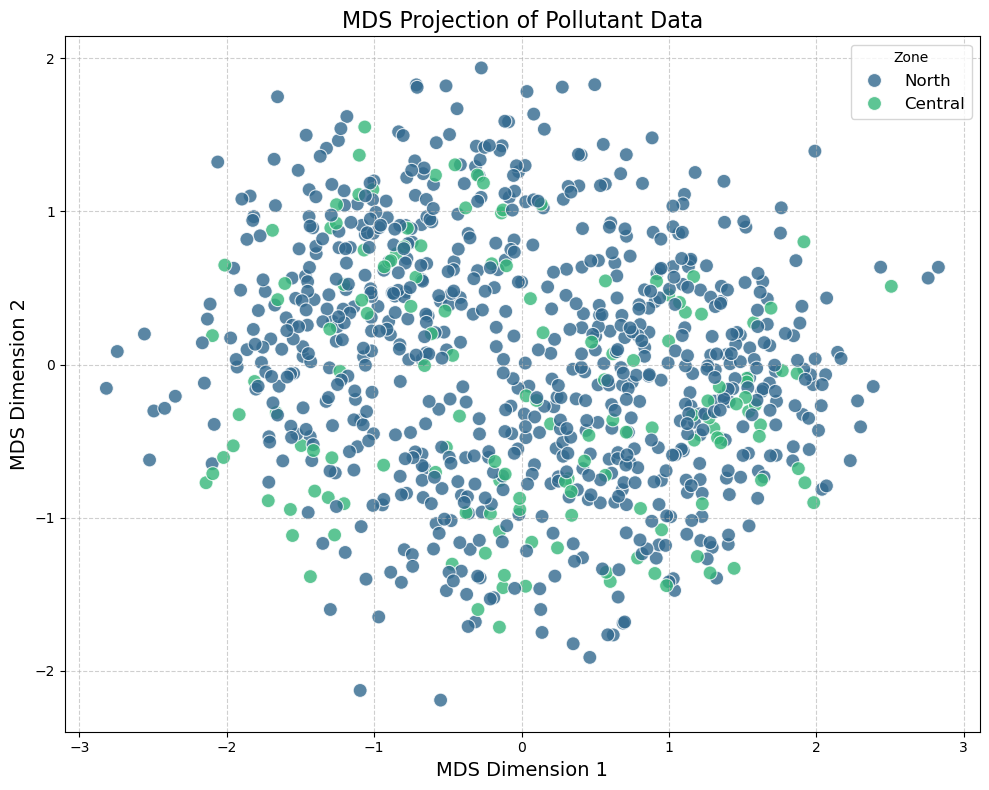

In [163]:
# Create a scatter plot of the MDS results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='MDS_X', 
    y='MDS_Y', 
    data=data_filtered, 
    hue=hue,  # Replace 'Category' with the column you want to use for color grouping
    palette='viridis',  # Choose a suitable color palette
    s=100,  # Marker size
    alpha=0.8  # Marker transparency
)

# Add labels and title
plt.title('MDS Projection of Pollutant Data', fontsize=16)
plt.xlabel('MDS Dimension 1', fontsize=14)
plt.ylabel('MDS Dimension 2', fontsize=14)

# Add legend
plt.legend(title=hue, fontsize=12)  # Adjust as per the hue variable
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()

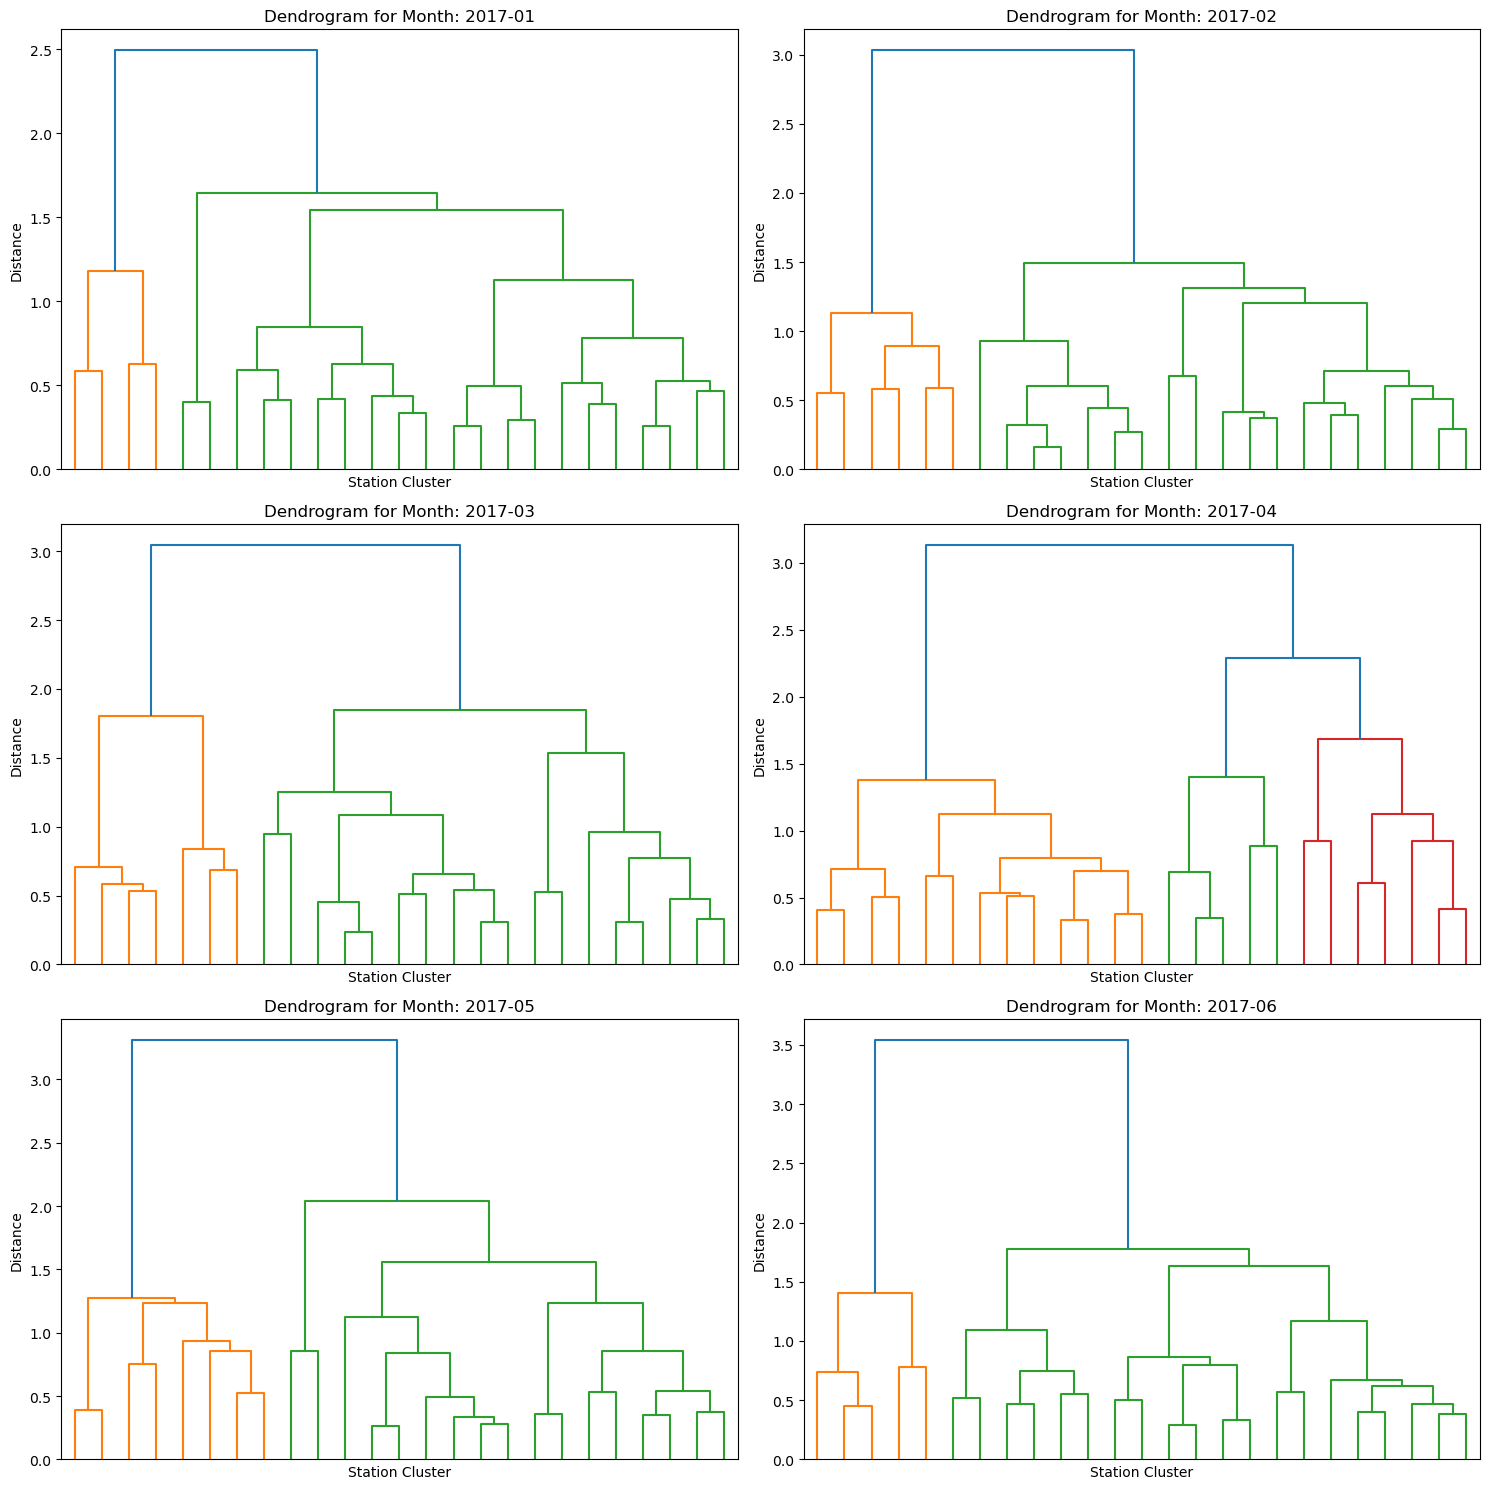

In [165]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid for dendrograms
axes = axes.flatten()

# Get unique months or seasons for clustering comparisons (optional)
unique_months = data_filtered['Month'].unique()

for i, month in enumerate(unique_months[:6]):  # Limit to 6 for visualization
    # Filter data for the current time period
    month_data = data_filtered[data_filtered['Month'] == month]
    
    if month_data.empty:
        continue  # Skip if no data for the current month

    # Combine spatial and pollutant data for clustering
    coords_and_concentration = month_data[['Latitude', 'Longitude'] + pollutants].to_numpy()
    
    # Perform hierarchical clustering
    Z = linkage(coords_and_concentration, method='ward')  # Ward's method minimizes variance
    
    # Plot dendrogram
    dendrogram(
        Z,
        ax=axes[i],
        truncate_mode='lastp',
        leaf_rotation=90,
        leaf_font_size=10,
        no_labels=True
    )
    axes[i].set_title(f"Dendrogram for Month: {month}", fontsize=12)
    axes[i].set_xlabel("Station Cluster", fontsize=10)
    axes[i].set_ylabel("Distance", fontsize=10)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

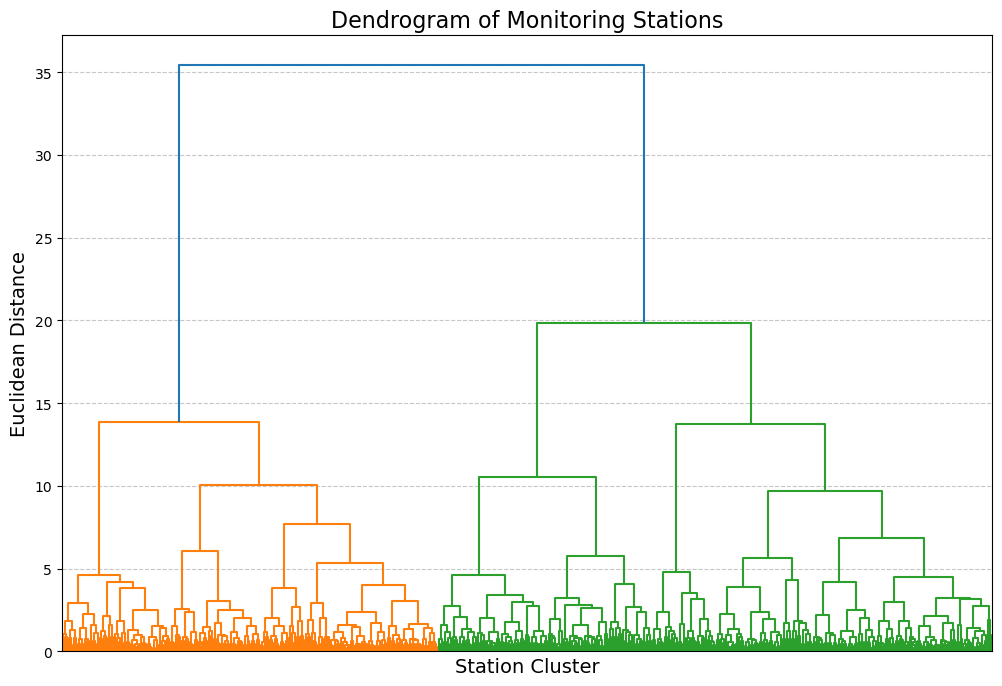

In [185]:
# Step 3: Hierarchical Clustering
# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(data_filtered[pollutants], method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=12)  # Removed truncate_mode to show all clusters
plt.title('Dendrogram of Monitoring Stations', fontsize=16)
plt.xlabel('Station Cluster', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Remove x-axis tick values
plt.xticks([])

plt.show()

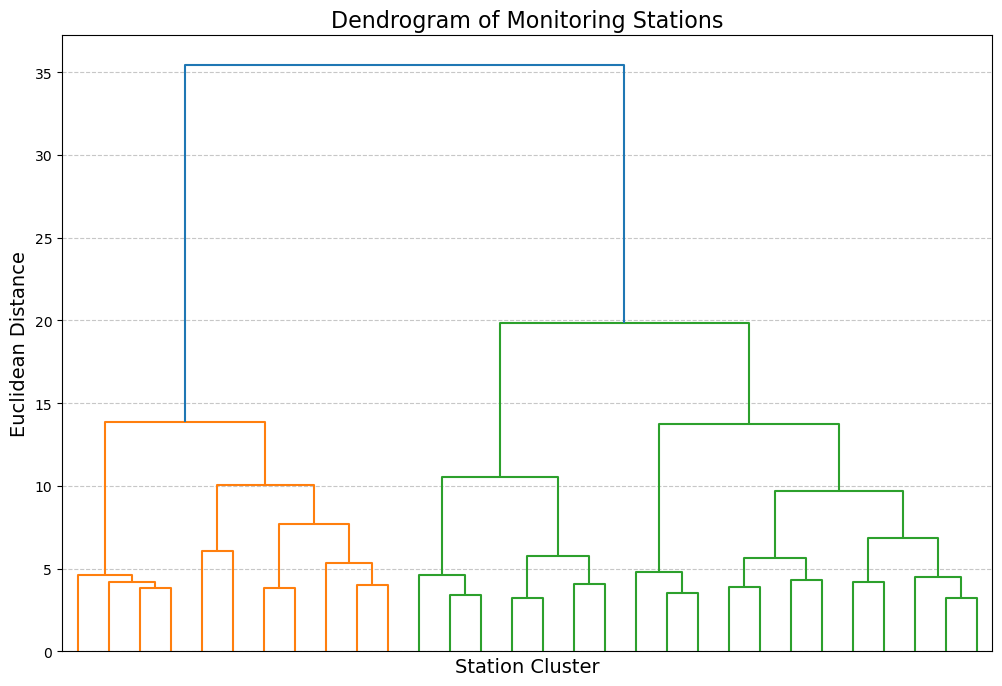

In [191]:
# Step 3: Hierarchical Clustering
# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(data_filtered[pollutants], method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram of Monitoring Stations', fontsize=16)
plt.xlabel('Station Cluster', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Remove x-axis tick values
plt.xticks([])

plt.show()

In [192]:
# Step 4: Extract Clusters
# Define the number of clusters (can be tuned based on dendrogram inspection)
num_clusters = 25
data_filtered['Cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

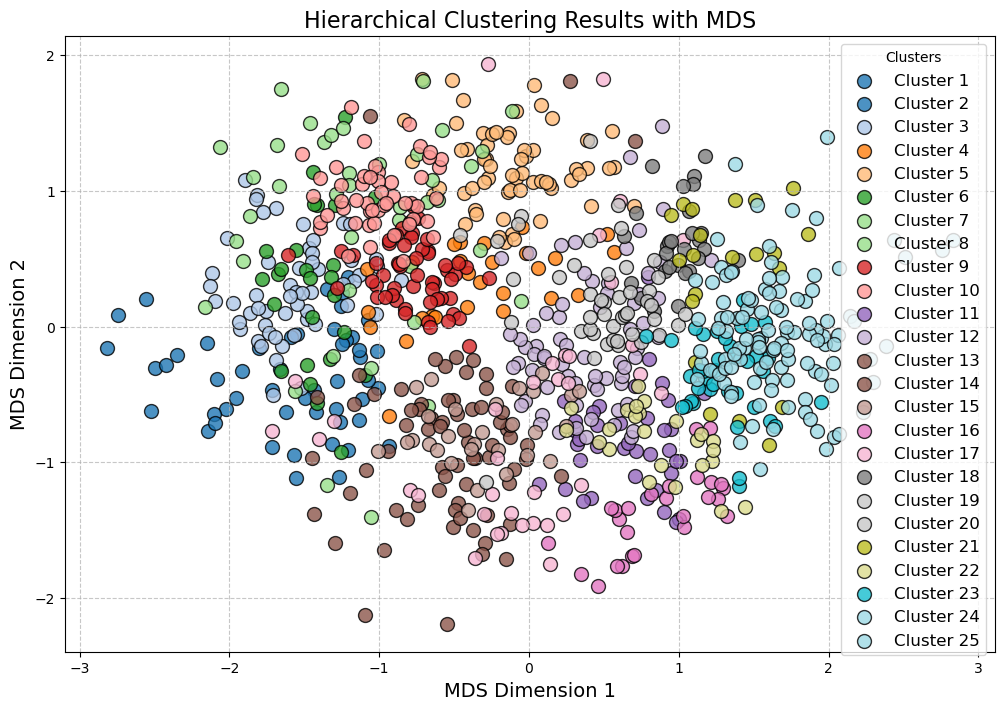

In [193]:
# Step 5: Visualize Clusters with MDS
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))
for cluster, color in zip(range(1, num_clusters + 1), colors):
    cluster_data = data_filtered[data_filtered['Cluster'] == cluster]
    plt.scatter(cluster_data['MDS_X'], cluster_data['MDS_Y'], label=f'Cluster {cluster}', color=color, s=100, edgecolor='k', alpha=0.8)
plt.title('Hierarchical Clustering Results with MDS', fontsize=16)
plt.xlabel('MDS Dimension 1', fontsize=14)
plt.ylabel('MDS Dimension 2', fontsize=14)
plt.legend(title='Clusters', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [194]:
data_filtered['Cluster'].unique()

array([ 9,  8,  1, 10,  3, 20, 19,  6,  4,  7, 13,  2, 12, 15, 14, 11, 22,
       23, 17, 24, 25, 21, 16, 18,  5])

<Figure size 1400x1000 with 0 Axes>

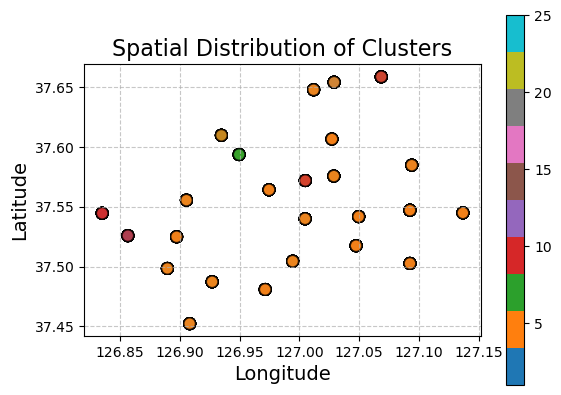

In [195]:
# Step 6: Map Clusters to Geographic Locations
# Convert to GeoDataFrame for spatial plotting
data_filtered['geometry'] = data_filtered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(data_filtered, geometry='geometry')

plt.figure(figsize=(14, 10))
gdf.plot(column='Cluster', legend=True, cmap='tab10', markersize=70, alpha=0.7, edgecolor='black')
plt.title('Spatial Distribution of Clusters', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [196]:
# Adjust `threshold` based on dataset spatial distribution
distance_threshold = 0.1  # Example threshold, adjust as needed
w = DistanceBand.from_dataframe(gdf, threshold=distance_threshold, binary=True)

In [197]:
# Check if there are any islands (points with no neighbors)
disconnected_points = [id for id, neighbors in w.neighbors.items() if len(neighbors) == 0]
if disconnected_points:
    print(f"Warning: {len(disconnected_points)} points are disconnected. Consider increasing the threshold.")


In [198]:
# Calculate Global Moran's I for a selected pollutant (e.g., PM2.5)
moran = Moran(gdf['PM2.5'], w)
print(f"Global Moran's I: {moran.I}, p-value: {moran.p_sim}")


Global Moran's I: 0.0055296294540080546, p-value: 0.008


In [199]:
# Calculate Local Moran's I for the same pollutant
local_moran = Moran_Local(gdf['PM2.5'], w)
gdf['Local_I'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim
gdf['Cluster_Type'] = ['Hotspot' if i > 0 and p < 0.05 else 'Coldspot' if i < 0 and p < 0.05 else 'Not Significant' 
                        for i, p in zip(local_moran.Is, local_moran.p_sim)]


In [203]:
gdf.set_crs(epsg=4326, inplace=True)

Month  Station code   Latitude   Longitude       SO2       NO2  \
0    2017-01           101  37.572016  127.005008 -0.085184  0.572429   
1    2017-01           102  37.564263  126.974676 -0.003494  0.643129   
2    2017-01           103  37.540033  127.004850  0.203512  0.239727   
3    2017-01           104  37.609823  126.934848  0.043981 -0.138984   
4    2017-01           105  37.593742  126.949679  0.918623 -0.002253   
..       ...           ...        ...         ...       ...       ...   
895  2019-12           121  37.487355  126.927102 -0.545948  0.676898   
896  2019-12           122  37.504547  126.994458 -0.594635  0.858986   
897  2019-12           123  37.517528  127.047470 -0.795471  0.514940   
898  2019-12           124  37.502686  127.092509 -0.444226  0.650045   
899  2019-12           125  37.544962  127.136792 -0.720701  0.530763   

           O3        CO      PM10     PM2.5     MDS_X     MDS_Y     Zone  \
0   -0.492733  0.543834  0.343492  0.529340 -0.743354  0.800206    North   
1   -0.530298  0.280349  0.384165  0.580765 -0.778287  0.692728    North   
2   -0.645645  0.375424  0.160667  0.468138 -0.677528  0.555030    North   
3   -0.531283  0.935344  0.373594  0.341232 -0.679478  0.914491    North   
4   -0.321265  0.663200  0.502669  0.324272 -1.303641 -0.021002    North   
..        ...       ...       ...       ...       ...       ...      ...   
895 -0.717574  0.430142  0.103504  0.243393 -0.258903  1.185914  Central   
896 -0.450113 -0.180464  0.255512  0.392667 -0.112778  1.117412    North   
897 -0.747557  0.638650  0.066996  0.301254 -0.147967  1.398864    North   
898 -0.862947  0.810839 -0.144474 -0.029967 -0.218707  1.431399    North   
899 -0.810448  0.604601  0.321152  0.724028 -0.489095  1.502878    North   

     Cluster                    geometry   Local_I  p_value     Cluster_Type  
0          9  POINT (127.00501 37.57202) -0.067955    0.018         Coldspot  
1          9  POINT (126.97468 37.56426)  0.009081    0.381  Not Significant  
2          9  POINT (127.00485 37.54003) -0.034302    0.113  Not Significant  
3          8  POINT (126.93485 37.60982) -0.016027    0.321  Not Significant  
4          1  POINT (126.94968 37.59374) -0.014983    0.280  Not Significant  
..       ...                         ...       ...      ...              ...  
895        5  POINT (126.92710 37.48735)  0.036676    0.043          Hotspot  
896        5  POINT (126.99446 37.50455)  0.000024    0.492  Not Significant  
897        5  POINT (127.04747 37.51753) -0.032054    0.068  Not Significant  
898        5  POINT (127.09251 37.50269)  0.003456    0.184  Not Significant  
899        5  POINT (127.13679 37.54496) -0.083020    0.171  Not Significant  

[900 rows x 18 columns]

In [253]:
gdf = gdf.to_crs(epsg=4326)

C:\Users\elias\AppData\Local\Temp\ipykernel_2652\3621635308.py:4: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



<Figure size 1400x1000 with 0 Axes>

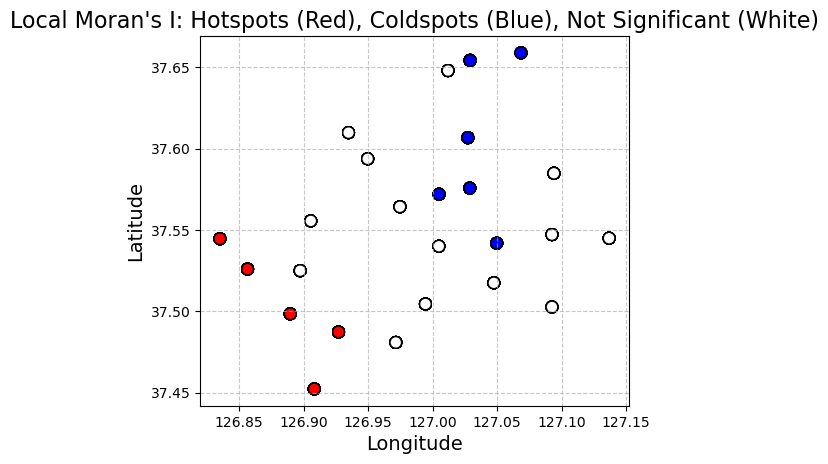

In [254]:
# Plot Local Moran's I results
plt.figure(figsize=(14, 10))
colors = {'Hotspot': 'red', 'Coldspot': 'blue', 'Not Significant': 'white'}
gdf.plot(column='Cluster_Type', legend=True, edgecolor='black',
         color=[colors[ct] for ct in gdf['Cluster_Type']], alpha=1, markersize=70)
plt.title("Local Moran's I: Hotspots (Red), Coldspots (Blue), Not Significant (White)", fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [255]:
gdf.head()

Month  Station code   Latitude   Longitude       SO2       NO2        O3  \
0  2017-01           101  37.572016  127.005008 -0.085184  0.572429 -0.492733   
1  2017-01           102  37.564263  126.974676 -0.003494  0.643129 -0.530298   
2  2017-01           103  37.540033  127.004850  0.203512  0.239727 -0.645645   
3  2017-01           104  37.609823  126.934848  0.043981 -0.138984 -0.531283   
4  2017-01           105  37.593742  126.949679  0.918623 -0.002253 -0.321265   

         CO      PM10     PM2.5     MDS_X     MDS_Y   Zone  Cluster  \
0  0.543834  0.343492  0.529340 -0.743354  0.800206  North        9   
1  0.280349  0.384165  0.580765 -0.778287  0.692728  North        9   
2  0.375424  0.160667  0.468138 -0.677528  0.555030  North        9   
3  0.935344  0.373594  0.341232 -0.679478  0.914491  North        8   
4  0.663200  0.502669  0.324272 -1.303641 -0.021002  North        1   

                     geometry   Local_I  p_value     Cluster_Type  
0  POINT (127.00501 37.57202) -0.067955    0.018         Coldspot  
1  POINT (126.97468 37.56426)  0.009081    0.381  Not Significant  
2  POINT (127.00485 37.54003) -0.034302    0.113  Not Significant  
3  POINT (126.93485 37.60982) -0.016027    0.321  Not Significant  
4  POINT (126.94968 37.59374) -0.014983    0.280  Not Significant

C:\Users\elias\AppData\Local\Temp\ipykernel_2652\355837339.py:8: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



<Figure size 1400x1000 with 0 Axes>

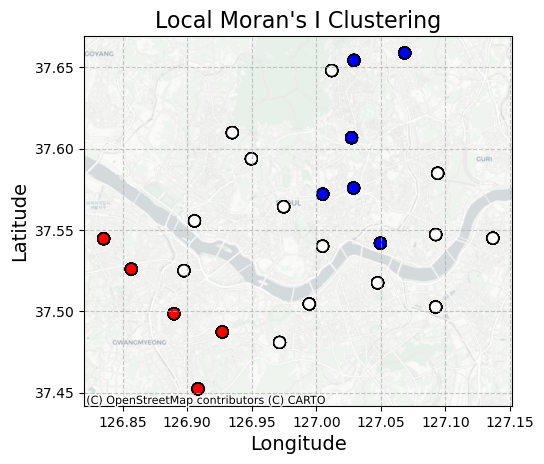

In [256]:
# Plot Local Moran's I results with Seoul map as underlayer
plt.figure(figsize=(14, 10))

# Define colors for clusters
colors = {'Hotspot': 'red', 'Coldspot': 'blue', 'Not Significant': 'white'}

# Plot the GeoDataFrame with the Local Moran's I results
ax = gdf.plot(
    column='Cluster_Type',
    legend=True,
    edgecolor='black',
    color=[colors[ct] for ct in gdf['Cluster_Type']],
    alpha=1,
    markersize=70
)

# Add the Seoul basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and labels
plt.title("Local Moran's I Clustering", fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [257]:
# Step 8: Integration with Geographic Data using Voronoi Diagrams
# Generate Voronoi polygons
coords = gdf[['Longitude', 'Latitude']].values
vor = Voronoi(coords)
voronoi_polygons = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        voronoi_polygons.append(polygon)


In [258]:
# Create a GeoDataFrame for Voronoi polygons
voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_polygons)


In [259]:
# Add cluster information to Voronoi polygons
voronoi_gdf['Cluster'] = None
for idx, point in gdf.iterrows():
    for poly_idx, poly in enumerate(voronoi_gdf.geometry):
        if poly.contains(point.geometry):
            voronoi_gdf.loc[poly_idx, 'Cluster'] = point['Cluster']
            break


In [260]:
bounding_box = gdf.unary_union.buffer(0.1)  # Adjust buffer size as needed
voronoi_gdf = gpd.clip(voronoi_gdf, bounding_box)

<Figure size 1400x1000 with 0 Axes>

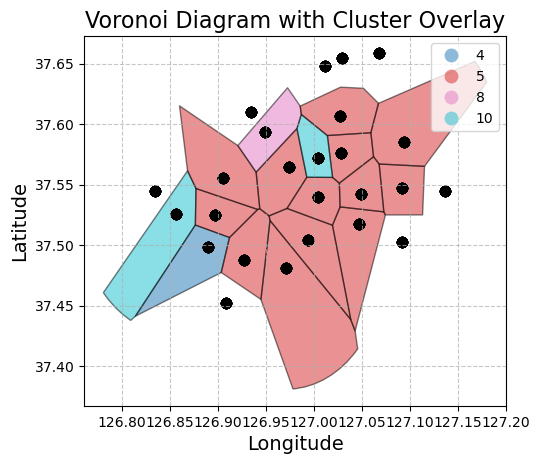

In [261]:
# Plot Voronoi diagram with clusters
plt.figure(figsize=(14, 10))
voronoi_gdf.plot(column='Cluster', cmap='tab10', legend=True, edgecolor='black', alpha=0.5)
gdf.plot(ax=plt.gca(), color='black', markersize=50)
plt.title('Voronoi Diagram with Cluster Overlay', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [268]:
# Step 1: Generate Voronoi polygons
coords = gdf[['Longitude', 'Latitude']].values
vor = Voronoi(coords)

# Add a bounding box with extra margin to ensure all points are included
margin = 0.2  # Adjust margin size as needed
min_x, min_y = coords.min(axis=0) - margin
max_x, max_y = coords.max(axis=0) + margin
bounding_box = box(min_x, min_y, max_x, max_y)

In [269]:
voronoi_polygons = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        # Intersect with bounding box to clip infinite polygons
        clipped_polygon = polygon.intersection(bounding_box)
        voronoi_polygons.append(clipped_polygon)

# Create a GeoDataFrame for Voronoi polygons
voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_polygons, crs=gdf.crs)

In [270]:
# Step 4: Verify geometry validity and handle invalid polygons
voronoi_gdf['geometry'] = voronoi_gdf['geometry'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))

In [271]:
# Step 2: Add cluster information to Voronoi polygons
voronoi_gdf['Cluster'] = None
for idx, point in gdf.iterrows():
    for poly_idx, poly in enumerate(voronoi_gdf.geometry):
        if poly.contains(point.geometry):
            voronoi_gdf.loc[poly_idx, 'Cluster'] = point['Cluster']
            break

In [272]:
# Check for any points not included in polygons
missing_points = gdf[~gdf.geometry.apply(lambda pt: any(poly.contains(pt) for poly in voronoi_gdf.geometry))]
if not missing_points.empty:
    print(f"Warning: {len(missing_points)} points are not included in any Voronoi polygons.")
    # Optionally assign these points to the nearest polygon
    from shapely.ops import nearest_points
    for idx, point in missing_points.iterrows():
        nearest_poly = min(voronoi_gdf.geometry, key=lambda poly: poly.distance(point.geometry))
        voronoi_gdf.loc[voronoi_gdf.geometry == nearest_poly, 'Cluster'] = point['Cluster']

<Figure size 1400x1000 with 0 Axes>

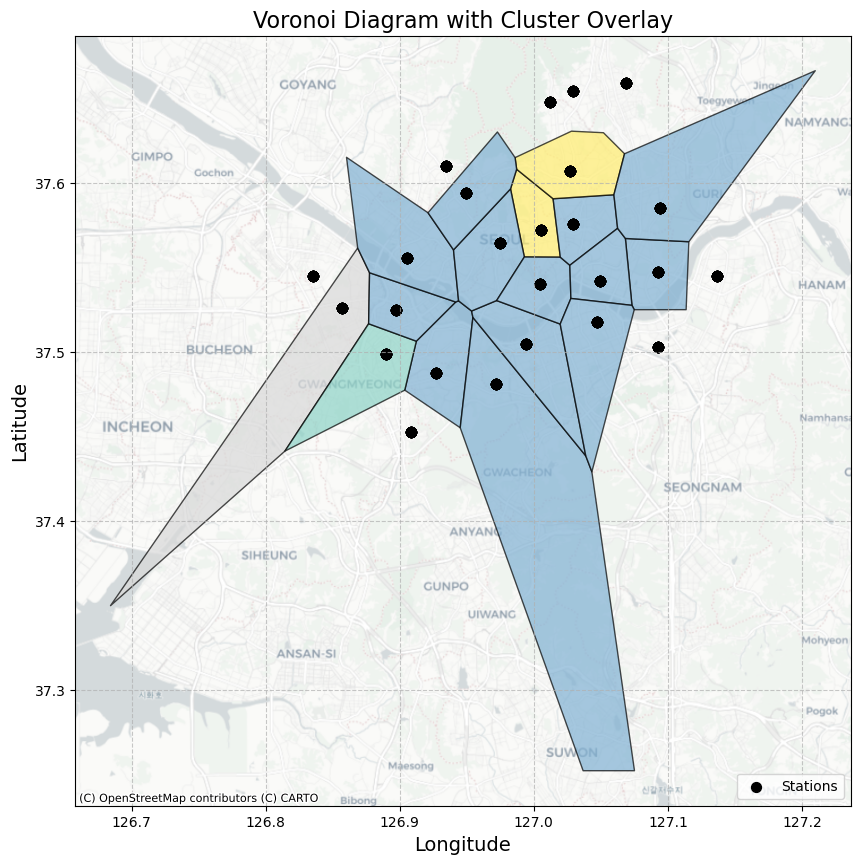

In [273]:
# Step 3: Plot Voronoi diagram with enhancements
plt.figure(figsize=(14, 10))

# Plot Voronoi polygons with clusters
ax = voronoi_gdf.plot(
    column='Cluster',
    cmap='Set3',  # Use a visually distinct colormap
    legend=True,
    edgecolor='black',
    alpha=0.7,
    figsize=(14, 10)
)

# Plot original points (stations) on top
gdf.plot(ax=ax, color='black', markersize=50, label='Stations')

# Add basemap for context
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add titles and labels
plt.title('Voronoi Diagram with Cluster Overlay', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [30]:
############################################################################

In [33]:
# Step 1: Temporal Decomposition using LOESS (daily aggregated data)
loess_results = {}
for pollutant in pollutant_columns:
    smoothed = lowess(daily_data[pollutant], pd.to_datetime(daily_data['Date']), frac=0.1, return_sorted=False)
    loess_results[pollutant] = smoothed
    daily_data[f'{pollutant}_Trend'] = smoothed

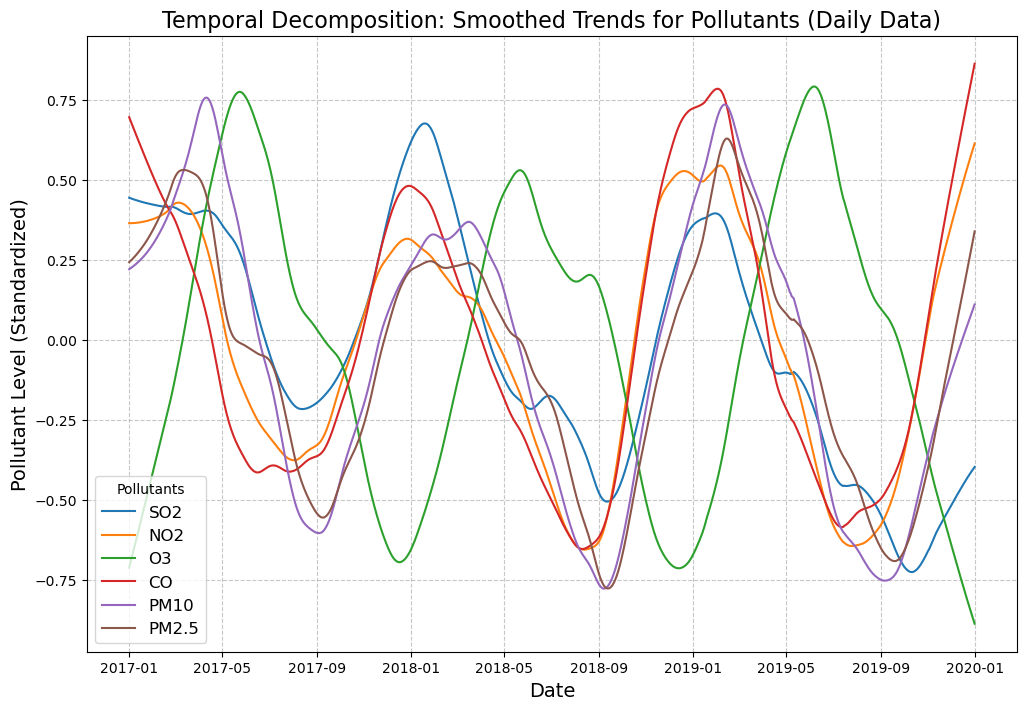

In [36]:
# Plot smoothed trends for each pollutant
plt.figure(figsize=(12, 8))
for pollutant in pollutant_columns:
    plt.plot(pd.to_datetime(daily_data['Date']), daily_data[f'{pollutant}_Trend'], label=pollutant)
plt.title('Temporal Decomposition: Smoothed Trends for Pollutants (Daily Data)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Pollutant Level (Standardized)', fontsize=14)
plt.legend(title='Pollutants', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [37]:
# Step 2: Temporal Autocorrelation
# Calculate Moran's I for PM2.5 at a monthly scale
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.to_period('M')
monthly_data = daily_data.groupby(['Month', 'Station code', 'Latitude', 'Longitude'])['PM2.5'].mean().reset_index()

temporal_morans = []
for period in monthly_data['Month'].unique():
    subset = monthly_data[monthly_data['Month'] == period]
    gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset['Longitude'], subset['Latitude']))
    w = DistanceBand.from_dataframe(gdf, threshold=0.1, binary=True)
    moran = Moran(gdf['PM2.5'], w)
    temporal_morans.append({'Month': period, 'Moran_I': moran.I, 'p_value': moran.p_sim})


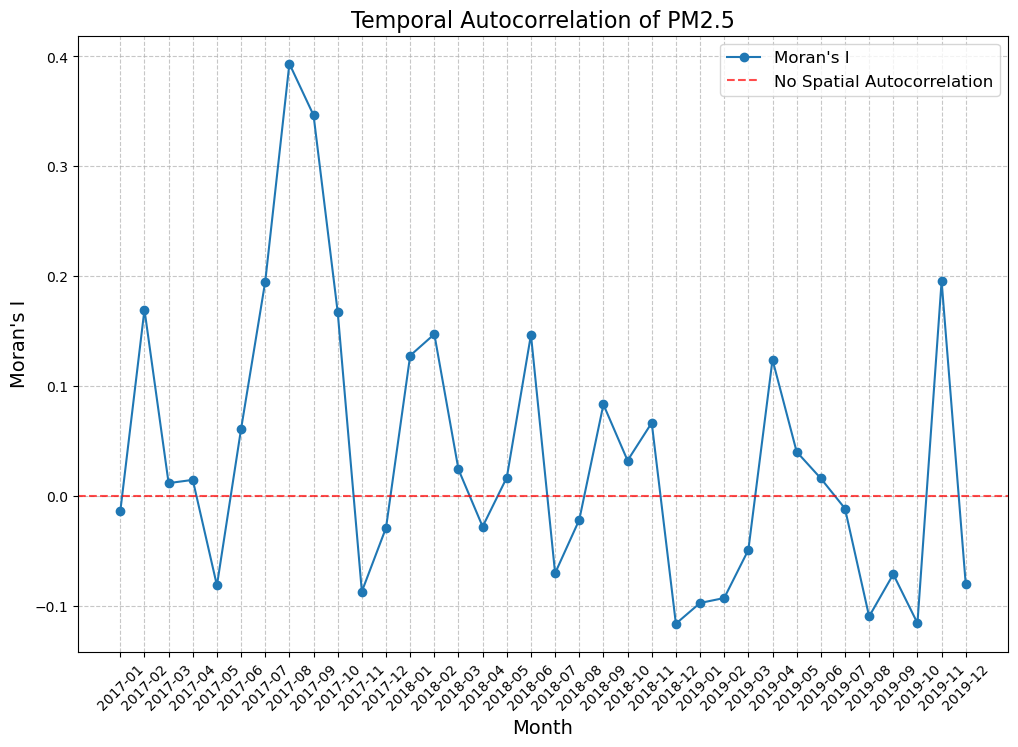

In [38]:
# Create a DataFrame for Moran's I over time
morans_df = pd.DataFrame(temporal_morans)
plt.figure(figsize=(12, 8))
plt.plot(morans_df['Month'].astype(str), morans_df['Moran_I'], marker='o', label="Moran's I")
plt.title('Temporal Autocorrelation of PM2.5', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel("Moran's I", fontsize=14)
plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='No Spatial Autocorrelation')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [39]:
# Step 3: Identify Stable Hotspots
# Evaluate cluster stability over time
stable_hotspots = []
for station in monthly_data['Station code'].unique():
    station_data = monthly_data[monthly_data['Station code'] == station]
    hotspot_consistency = (station_data['PM2.5'] > 0).mean()  # Fraction of months identified as hotspots
    stable_hotspots.append({'Station code': station, 'Consistency': hotspot_consistency})


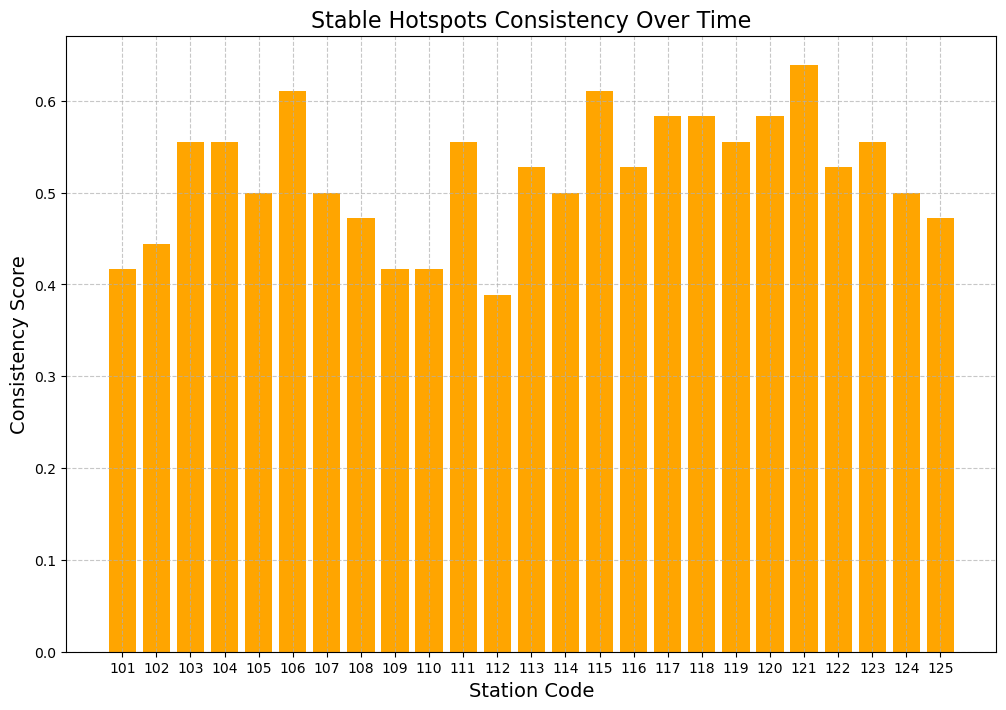

In [40]:
# Convert to DataFrame and visualize
stable_hotspots_df = pd.DataFrame(stable_hotspots)
plt.figure(figsize=(12, 8))
plt.bar(stable_hotspots_df['Station code'].astype(str), stable_hotspots_df['Consistency'], color='orange')
plt.title('Stable Hotspots Consistency Over Time', fontsize=16)
plt.xlabel('Station Code', fontsize=14)
plt.ylabel('Consistency Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


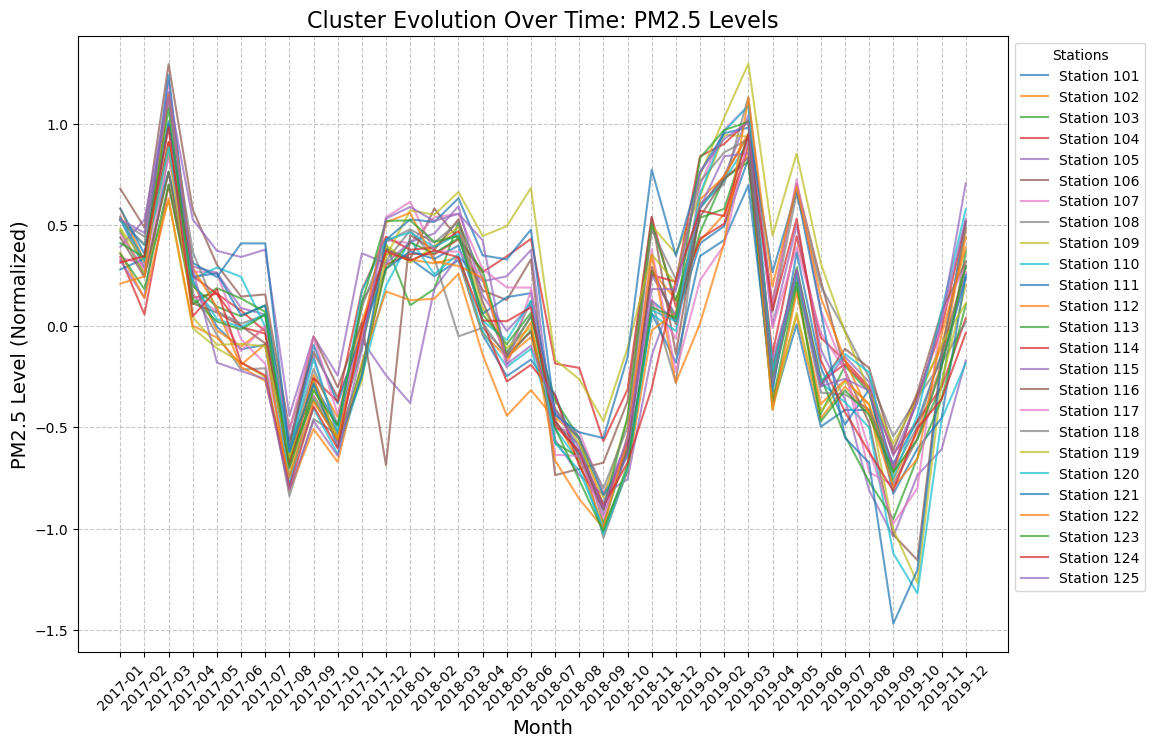

In [41]:
# Plot storyline visualization for cluster evolution
grouped = monthly_data.groupby(['Month', 'Station code'])['PM2.5'].mean().unstack()
plt.figure(figsize=(12, 8))
for station in grouped.columns:
    plt.plot(grouped.index.astype(str), grouped[station], label=f'Station {station}', alpha=0.7)
plt.title('Cluster Evolution Over Time: PM2.5 Levels', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('PM2.5 Level (Normalized)', fontsize=14)
plt.legend(title='Stations', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


In [77]:
#######################################################################

In [318]:
# Monthly Aggregation
monthly_data = data.groupby(['Month', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

# Use monthly_data for clustering
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
data_filtered = monthly_data.dropna()

In [319]:
# Calculate pairwise flow for each pollutant
flows = []
stations = monthly_data['Station code'].unique()

In [320]:
for pollutant in pollutant_columns:
    for i in range(len(stations)):
        for j in range(len(stations)):
            if i != j:
                station_i = monthly_data[monthly_data['Station code'] == stations[i]].iloc[0]
                station_j = monthly_data[monthly_data['Station code'] == stations[j]].iloc[0]
                
                flow_intensity = station_i[pollutant] - station_j[pollutant]
                flows.append({
                    'From': stations[i],
                    'To': stations[j],
                    'Pollutant': pollutant,
                    'Flow_Intensity': flow_intensity,
                    'From_Lat': station_i['Latitude'],
                    'From_Lon': station_i['Longitude'],
                    'To_Lat': station_j['Latitude'],
                    'To_Lon': station_j['Longitude']
                })

# Convert to a DataFrame for further analysis
flow_df = pd.DataFrame(flows)

In [321]:
# Normalize the Flow_Intensity column to handle varying concentration ranges
scaler = MinMaxScaler(feature_range=(0, 1))
flow_df['Normalized_Flow'] = scaler.fit_transform(flow_df[['Flow_Intensity']])

In [322]:
# Display a preview of the normalized flow DataFrame
print(flow_df[['From', 'To', 'Pollutant', 'Flow_Intensity', 'Normalized_Flow']].head())

   From   To Pollutant  Flow_Intensity  Normalized_Flow
0   101  102       SO2       -0.081690         0.472351
1   101  103       SO2       -0.288696         0.402287
2   101  104       SO2       -0.129165         0.456283
3   101  105       SO2       -1.003807         0.160249
4   101  106       SO2       -0.138574         0.453098


In [323]:
# Define a threshold for filtering edges (e.g., only keep flows above 50% of the normalized range)
flow_threshold = 0.75
filtered_flows = flow_df[flow_df['Normalized_Flow'] > flow_threshold]

# Create a new directed graph with filtered edges
G_filtered = nx.DiGraph()

In [324]:
# Add nodes
for station in stations:
    station_data = monthly_data[monthly_data['Station code'] == station].iloc[0]
    G_filtered.add_node(station, pos=(station_data['Longitude'], station_data['Latitude']))

# Add filtered edges
for _, row in filtered_flows.iterrows():
    G_filtered.add_edge(row['From'], row['To'], weight=row['Normalized_Flow'], pollutant=row['Pollutant'])


In [325]:
# Print graph information
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")

Number of nodes: 25
Number of edges: 100


In [326]:
# Optional: Print a few edges with attributes
print("Sample edges with attributes:")
for u, v, attrs in list(G_filtered.edges(data=True))[:5]:
    print(f"Edge from {u} to {v}, attributes: {attrs}")

Sample edges with attributes:
Edge from 101 to 119, attributes: {'weight': 0.7757805784279753, 'pollutant': 'NO2'}
Edge from 102 to 104, attributes: {'weight': 0.7647159858847736, 'pollutant': 'NO2'}
Edge from 102 to 119, attributes: {'weight': 0.7997099551583123, 'pollutant': 'NO2'}
Edge from 105 to 101, attributes: {'weight': 0.8397510133178929, 'pollutant': 'SO2'}
Edge from 105 to 102, attributes: {'weight': 0.8121019108280259, 'pollutant': 'SO2'}


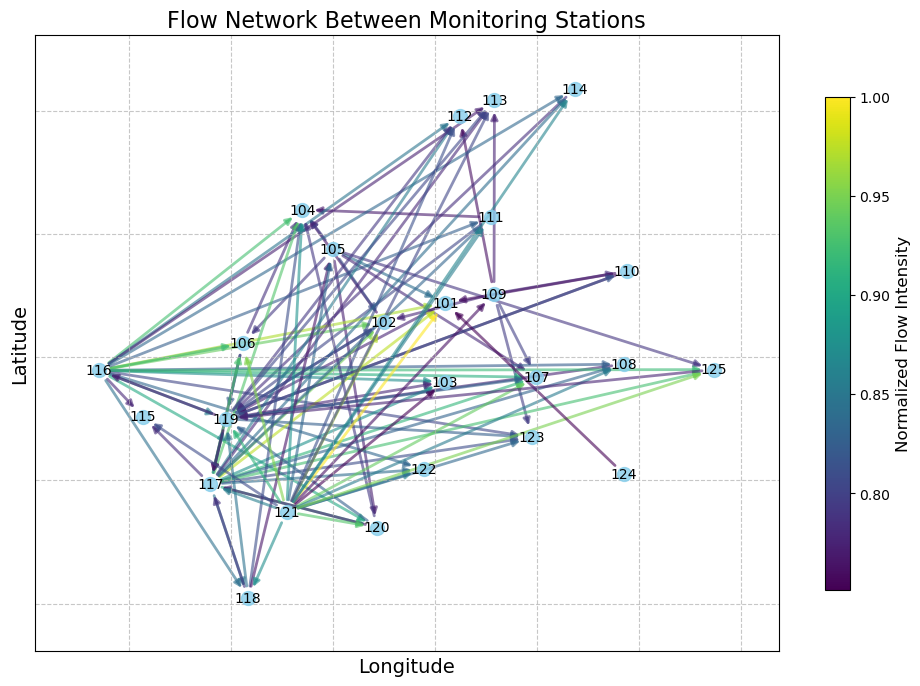

In [327]:
# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_filtered.nodes(data=True)}

# Draw the nodes
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_filtered, pos, node_size=100, node_color='skyblue', alpha=0.8)

# Extract edge data and weights
edges = G_filtered.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]  # Edge weights used for coloring

# Normalize edge weights for consistent coloring
norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [plt.cm.viridis(norm(weight)) for weight in edge_weights]

# Draw edges with color
nx.draw_networkx_edges(
    G_filtered, pos, edgelist=edges, edge_color=edge_colors, alpha=0.6, width=2
)

# Add labels for stations
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_color='black')

# Add a colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Use empty array, as the mappable is linked to the edges
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)
cbar.set_label('Normalized Flow Intensity', fontsize=12)

plt.title('Flow Network Between Monitoring Stations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

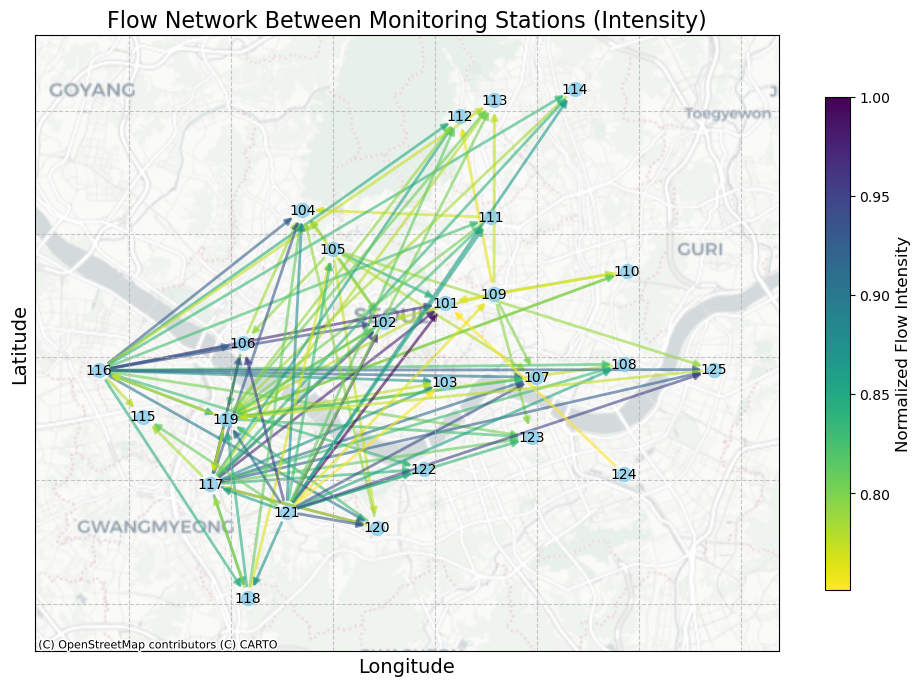

In [328]:
# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_filtered.nodes(data=True)}

# Draw the nodes
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current axis

# Draw the network nodes
nx.draw_networkx_nodes(G_filtered, pos, ax=ax, node_size=100, node_color='skyblue', alpha=0.8)

# Extract edge data and weights
edges = G_filtered.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]  # Edge weights used for coloring

# Normalize edge weights for consistent coloring
norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))

# Reverse colormap for lighter-to-darker effect
cmap = plt.cm.viridis_r  # Reverse 'viridis' colormap
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Draw edges with color
nx.draw_networkx_edges(
    G_filtered, pos, ax=ax, edgelist=edges, edge_color=edge_colors, alpha=0.6, width=2
)

# Add labels for stations
nx.draw_networkx_labels(G_filtered, pos, ax=ax, font_size=10, font_color='black')

# Add basemap for Seoul
# Ensure that the positions are in a proper geographic CRS (e.g., EPSG:4326)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# Add a colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Use empty array, as the mappable is linked to the edges
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Normalized Flow Intensity', fontsize=12)

# Set plot title and labels
plt.title('Flow Network Between Monitoring Stations (Intensity)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

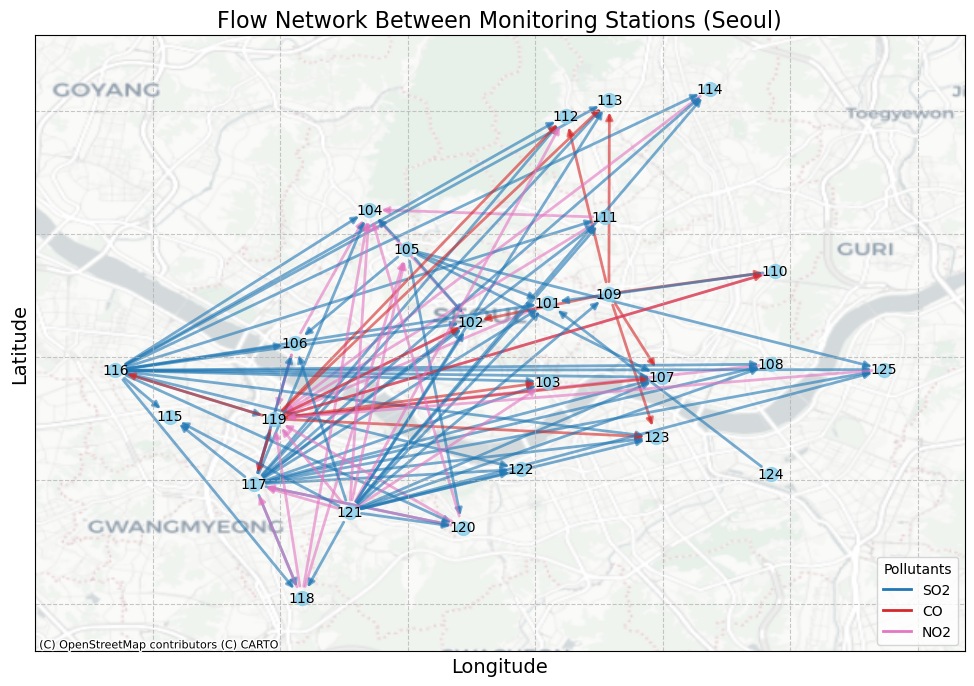

In [329]:
# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_filtered.nodes(data=True)}

# Draw the nodes
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current axis

nx.draw_networkx_nodes(G_filtered, pos, ax=ax, node_size=100, node_color='skyblue', alpha=0.8)

# Extract edge data and pollutants
edges = G_filtered.edges(data=True)
pollutants = [edge[2]['pollutant'] for edge in edges]  # Extract pollutants for edges

# Map pollutants to unique colors
unique_pollutants = list(set(pollutants))
cmap = plt.cm.tab10  # Use a distinct colormap
color_mapping = {pollutant: cmap(i / len(unique_pollutants)) for i, pollutant in enumerate(unique_pollutants)}
edge_colors = [color_mapping[edge[2]['pollutant']] for edge in edges]

# Draw edges with pollutant-based colors
nx.draw_networkx_edges(
    G_filtered, pos, ax=ax, edgelist=edges, edge_color=edge_colors, alpha=0.6, width=2
)

# Add labels for stations
nx.draw_networkx_labels(G_filtered, pos, ax=ax, font_size=10, font_color='black')

# Add basemap for Seoul
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# Add a legend for pollutants
legend_elements = [
    plt.Line2D([0], [0], color=color_mapping[pollutant], lw=2, label=pollutant)
    for pollutant in unique_pollutants
]
ax.legend(handles=legend_elements, loc='lower right', title='Pollutants')

# Set plot title and labels
plt.title('Flow Network Between Monitoring Stations (Seoul)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

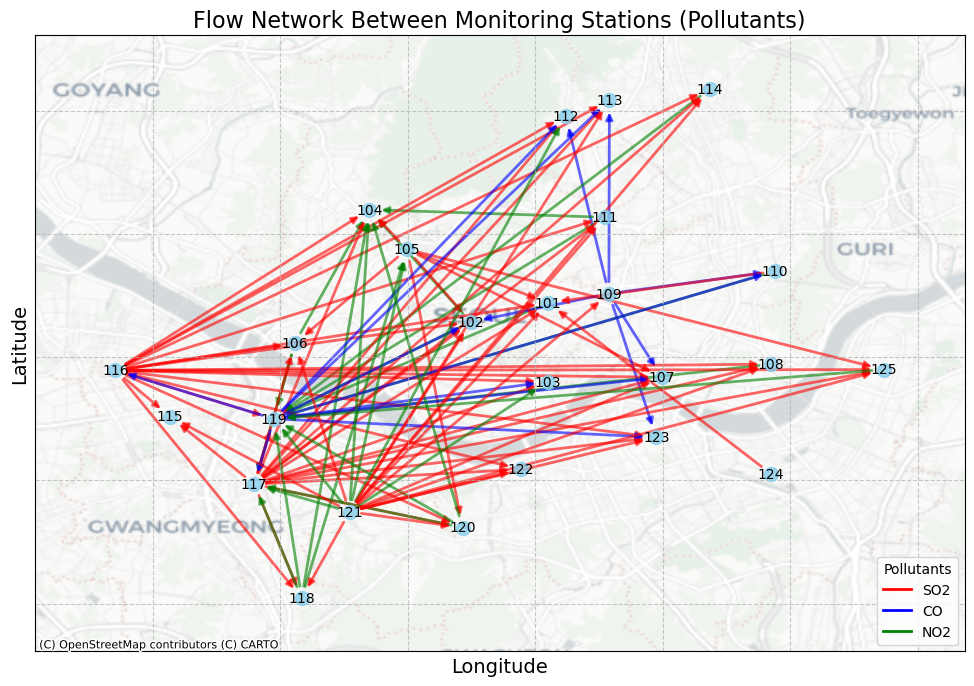

In [330]:
# Define a custom colormap with 3 distinct colors
custom_colors = ['red', 'blue', 'green']  # Example colors: orange-red, green, blue
cmap = mcolors.ListedColormap(custom_colors)

# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_filtered.nodes(data=True)}

# Draw the nodes
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get the current axis

nx.draw_networkx_nodes(G_filtered, pos, ax=ax, node_size=100, node_color='skyblue', alpha=0.8)

# Extract edge data and pollutants
edges = G_filtered.edges(data=True)
pollutants = [edge[2]['pollutant'] for edge in edges]  # Extract pollutants for edges

# Map pollutants to one of 3 colors
unique_pollutants = list(set(pollutants))
if len(unique_pollutants) > 3:
    raise ValueError("The number of unique pollutants exceeds the 3 available colors.")

color_mapping = {pollutant: custom_colors[i] for i, pollutant in enumerate(unique_pollutants)}
edge_colors = [color_mapping[edge[2]['pollutant']] for edge in edges]

# Draw edges with pollutant-based colors
nx.draw_networkx_edges(
    G_filtered, pos, ax=ax, edgelist=edges, edge_color=edge_colors, alpha=0.6, width=2
)

# Add labels for stations
nx.draw_networkx_labels(G_filtered, pos, ax=ax, font_size=10, font_color='black')

# Add basemap for Seoul
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# Add a legend for pollutants
legend_elements = [
    plt.Line2D([0], [0], color=color_mapping[pollutant], lw=2, label=pollutant)
    for pollutant in unique_pollutants
]
ax.legend(handles=legend_elements, loc='lower right', title='Pollutants')

# Set plot title and labels
plt.title('Flow Network Between Monitoring Stations (Pollutants)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [331]:
flow_df.head()

From   To Pollutant  Flow_Intensity   From_Lat    From_Lon     To_Lat  \
0   101  102       SO2       -0.081690  37.572016  127.005008  37.564263   
1   101  103       SO2       -0.288696  37.572016  127.005008  37.540033   
2   101  104       SO2       -0.129165  37.572016  127.005008  37.609823   
3   101  105       SO2       -1.003807  37.572016  127.005008  37.593742   
4   101  106       SO2       -0.138574  37.572016  127.005008  37.555580   

       To_Lon  Normalized_Flow  
0  126.974676         0.472351  
1  127.004850         0.402287  
2  126.934848         0.456283  
3  126.949679         0.160249  
4  126.905597         0.453098

In [332]:
# Assuming monthly_data contains a 'Month' column and 'Station code'
flow_df = flow_df.merge(
    monthly_data[['Station code', 'Month']],
    left_on='From',
    right_on='Station code',
    how='left'
)

In [333]:
# Drop the redundant 'Station code' column from the merge
flow_df = flow_df.drop(columns=['Station code'])

In [334]:
# Display the updated flow_df with temporal granularity
print(flow_df[['From', 'To', 'Pollutant', 'Flow_Intensity', 'Normalized_Flow', 'Month']].head())

   From   To Pollutant  Flow_Intensity  Normalized_Flow    Month
0   101  102       SO2        -0.08169         0.472351  2017-01
1   101  102       SO2        -0.08169         0.472351  2017-02
2   101  102       SO2        -0.08169         0.472351  2017-03
3   101  102       SO2        -0.08169         0.472351  2017-04
4   101  102       SO2        -0.08169         0.472351  2017-05


In [335]:
# Aggregate flows over months
flow_df_temporal = flow_df.groupby(['Month', 'From', 'To', 'Pollutant']).agg(
    Total_Flow=('Flow_Intensity', 'sum'),
    Average_Normalized_Flow=('Normalized_Flow', 'mean')
).reset_index()


In [336]:
# Display the temporal flows
print(flow_df_temporal.head())

     Month  From   To Pollutant  Total_Flow  Average_Normalized_Flow
0  2017-01   101  102        CO    0.263485                 0.589180
1  2017-01   101  102       NO2   -0.070700                 0.476071
2  2017-01   101  102        O3    0.037565                 0.512714
3  2017-01   101  102      PM10   -0.040673                 0.486234
4  2017-01   101  102     PM2.5   -0.051426                 0.482594


In [337]:
# Create a directed graph for the time-aggregated network
G_static = nx.DiGraph()

# Add nodes for each monitoring station
for station in aggregated_flows['From'].unique():
    station_data = monthly_data[monthly_data['Station code'] == station].iloc[0]
    G_static.add_node(station, pos=(station_data['Longitude'], station_data['Latitude']))

# Add edges with weights based on normalized total flow
for _, row in aggregated_flows.iterrows():
    G_static.add_edge(row['From'], row['To'], weight=row['Normalized_Total_Flow'], pollutant=row['Pollutant'])


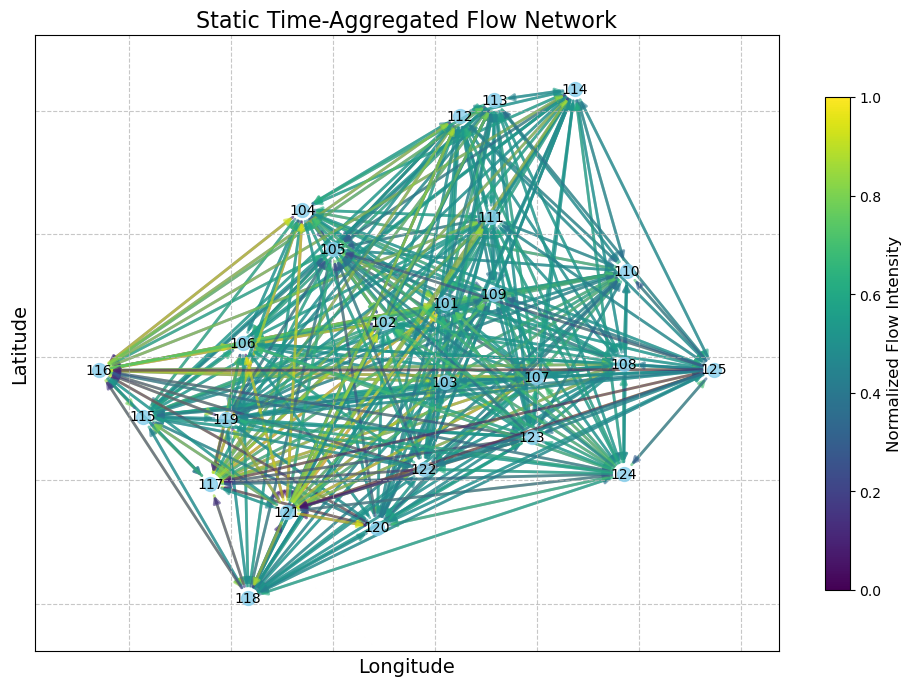

In [338]:
# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_static.nodes(data=True)}

# Draw the nodes
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_static, pos, node_size=100, node_color='skyblue', alpha=0.8)

# Extract edge data and weights
edges = G_static.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]  # Edge weights used for coloring

# Normalize edge weights for consistent coloring
norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [plt.cm.viridis(norm(weight)) for weight in edge_weights]

# Draw edges with color
nx.draw_networkx_edges(
    G_static, pos, edgelist=edges, edge_color=edge_colors, alpha=0.6, width=2
)

# Add labels for stations
nx.draw_networkx_labels(G_static, pos, font_size=10, font_color='black')

# Add a colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Use empty array, as the mappable is linked to the edges
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)
cbar.set_label('Normalized Flow Intensity', fontsize=12)

# Add titles and labels
plt.title('Static Time-Aggregated Flow Network', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [339]:
# Prepare data for Sankey diagram
# Aggregated flows for better visualization
aggregated_sankey_data = flow_df_temporal.groupby(['From', 'To']).agg(
    Total_Flow=('Total_Flow', 'sum')
).reset_index()


In [340]:
# Get sources, targets, and values
sources = aggregated_sankey_data['From']
targets = aggregated_sankey_data['To']
values = aggregated_sankey_data['Total_Flow']

In [341]:
# Create unique node labels (stations)
all_stations = list(set(sources).union(set(targets)))
station_indices = {station: i for i, station in enumerate(all_stations)}

# Map sources and targets to indices
source_indices = [station_indices[src] for src in sources]
target_indices = [station_indices[trg] for trg in targets]

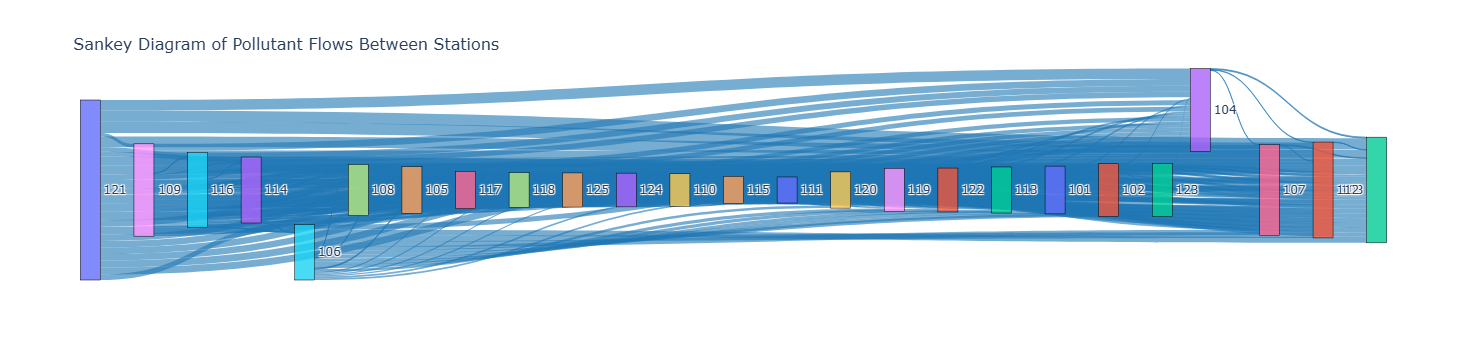

In [342]:
# Define the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_stations,  # Station labels
    ),
    link=dict(
        source=source_indices,  # Source indices
        target=target_indices,  # Target indices
        value=values,  # Flow values
        color='rgba(31, 119, 180, 0.6)',  # Optional: uniform color for links
    )
))

# Add title and styling
fig.update_layout(
    title_text="Sankey Diagram of Pollutant Flows Between Stations",
    font_size=12,
    title_font_size=16
)

# Show the diagram
fig.show()

In [346]:
# Create a directed graph for the time-aggregated network
G_temporal_graph = nx.DiGraph()

In [347]:
# Add nodes for each monitoring station
stations = set(flow_df_temporal['From']).union(set(flow_df_temporal['To']))
for station in stations:
    station_data = monthly_data[monthly_data['Station code'] == station].iloc[0]
    G_temporal_graph.add_node(
        station, pos=(station_data['Longitude'], station_data['Latitude'])
    )

# Add edges with attributes
for _, row in flow_df_temporal.iterrows():
    G_temporal_graph.add_edge(
        row['From'], row['To'],
        weight=row['Average_Normalized_Flow'], pollutant=row['Pollutant']
    )


In [348]:
# Extract positions for nodes
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G_temporal_graph.nodes(data=True)}

# Extract edge weights and pollutants
edges = G_temporal_graph.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
edge_labels = [edge[2]['pollutant'] for edge in edges]

In [349]:
# Normalize edge weights for line width
norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
line_widths = [norm(weight) * 5 for weight in edge_weights]  # Adjust scale as needed

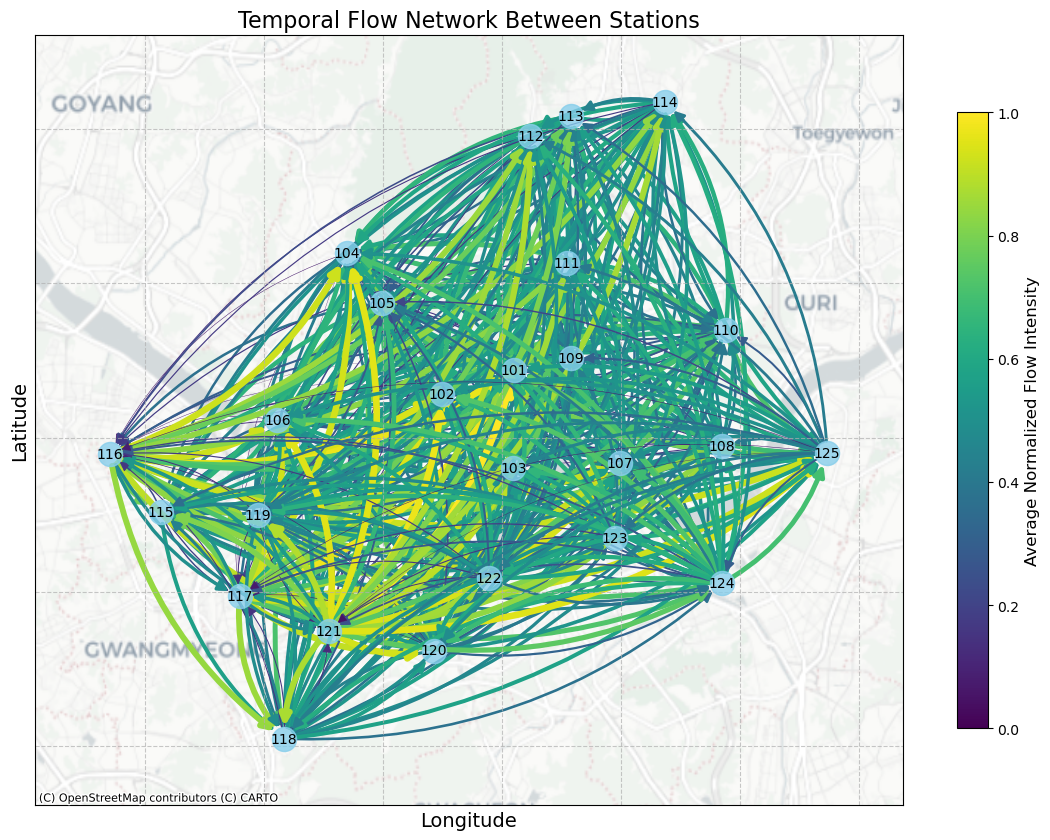

In [352]:
# Plot the graph
plt.figure(figsize=(14, 10))
ax = plt.gca()

# Draw nodes
nx.draw_networkx_nodes(G_temporal_graph, pos, ax=ax, node_size=300, node_color='skyblue', alpha=0.8)

# Draw edges with styles
nx.draw_networkx_edges(
    G_temporal_graph, pos, ax=ax, edgelist=edges,
    connectionstyle='arc3,rad=0.2',  # Curved edges
    arrowstyle='-|>',  # Arrow style
    arrowsize=15,  # Arrow size
    edge_color=edge_weights,  # Color edges by weight
    edge_cmap=plt.cm.viridis,  # Colormap for edges
    width=line_widths  # Line width scaled by weight
)

# Add node labels
nx.draw_networkx_labels(G_temporal_graph, pos, ax=ax, font_size=10, font_color='black')

# Add the Seoul basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# Add a colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Average Normalized Flow Intensity', fontsize=12)

# Add title and axis labels
plt.title('Temporal Flow Network Between Stations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()